# Face detection using Haar-like features

Code developed by Marcelo Ferrer and Aymen Merchaoui

In [12]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import skimage
import random

# Classifier + Training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Haar-like features
from skimage.transform import integral_image, rescale, resize
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature


## Step 1: Create the datasets
In this notebook we are going to use a face database included in the scikit-learn library. 

Number of faces: 13233 | Size of images: (62, 47)


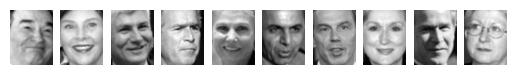

In [13]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
print(f"Number of faces: {faces.images.shape[0]} | Size of images: {faces.images.shape[1:]}")

fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(faces.images[np.random.randint(0,faces.images.shape[0])], cmap='gray')
    ax[i].axis('off')

In order to compute the Haar-like features and to speed up the computations, we are going to reduce the dataset and resize each input image to a (25,25) square.

(400, 25, 25)


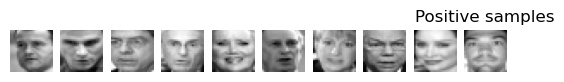

In [14]:
# Parameters
N_SAMPLES = 400
SIZE = (25, 25)

random_samples = np.random.randint(0, faces.images.shape[0], N_SAMPLES)

positive_patches = np.array([skimage.transform.resize(img, SIZE, anti_aliasing=True) for img in faces.images[random_samples]])

print(positive_patches.shape)

fig, ax = plt.subplots(1,10)
plt.title("Positive samples")
for i in range(10):
    ax[i].imshow(positive_patches[np.random.randint(0,positive_patches.shape[0])], cmap='gray')
    ax[i].axis('off')

Since we also need some negative examples, we are going to extract patches from sample images included in the scikit-image library. 

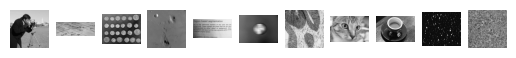

In [15]:
sample_images = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field','grass']
negative_images = []
for name in sample_images:
    img = getattr(skimage.data, name)()
    if len(img.shape) == 3:
            img = skimage.color.rgb2gray(img)
    negative_images.append(img)  
    
fig, ax = plt.subplots(1, len(negative_images))    
for idx,img in enumerate(negative_images):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].axis('off')
plt.show()

From these images we are going to extract some 25x25 patches at different scales:

(495, 25, 25)


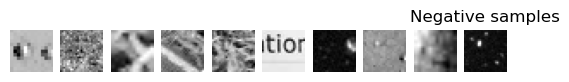

In [16]:
def extract_patches(img, n, patch_size, scale=1.0):
    new_size = (int(scale*patch_size[0]), int(scale*patch_size[1]))
    extractor = sklearn.feature_extraction.image.PatchExtractor(patch_size=new_size, max_patches=n)
    patches = extractor.transform(img[np.newaxis])
    
    if scale != 1:
        patches = np.array([skimage.transform.resize(patch, patch_size) for patch in patches])

    return patches

negative_patches = np.vstack([extract_patches(im, 15, SIZE, scale) 
                                for im in negative_images for scale in [0.5, 1.0, 1.5]])
print(negative_patches.shape)

fig, ax = plt.subplots(1,10)
plt.title('Negative samples')
for i in range(10):
    ax[i].imshow(negative_patches[np.random.randint(0,negative_patches.shape[0])], cmap='gray')
    ax[i].axis('off')

## Step 2: Extract Haar-like features

Number of features in an (25, 25) image = 101400


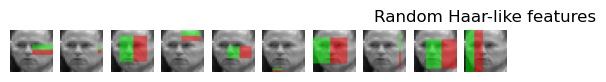

In [17]:
# Extract the haar features for the current image.
# The features specified by 'feature_type'  are computed
# from the integral image only at the positions specified by 'feature_coord'
# If both parameters are none, all the haar features at all the image positions are
# computed
def extract_feature_image(img, feature_type,feature_coord=None):
    
    ii = skimage.transform.integral_image(img)
    features = skimage.feature.haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)
    return features

# Parameter
# Types of features to compute (for simplicity, only two)
FEATURE_TYPES = ['type-2-x', 'type-2-y']

# Returns all the coordinates and feature types that can be computed in an image
# of a given size
feature_coord, feature_type =\
    skimage.feature.haar_like_feature_coord(width=SIZE[1], height=SIZE[0],
                            feature_type=FEATURE_TYPES)

print(f"Number of features in an {SIZE} image = {feature_coord.shape[0]}")
fig, ax = plt.subplots(1,10)
plt.title("Random Haar-like features")

for idx in range(10):
    image = positive_patches[0]
    image = skimage.feature.draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[np.random.randint(0, feature_coord.shape[0])]])
    ax[idx].imshow(image)
    ax[idx].axis('off')
plt.show()

In [18]:
dataset = np.vstack([positive_patches, negative_patches])

t_start = time()
features = np.vstack([extract_feature_image(img, FEATURE_TYPES) for img in dataset])
time_full_feature_comp = time() - t_start

print(f"Computed {features.shape} features in {time_full_feature_comp}s")

Computed (895, 101400) features in 164.03877592086792s


Once the features are computed, we can train a classifier in order to distinguish between face and non-face patches.

In [19]:
labels = np.zeros((features.shape[0]))
labels[:positive_patches.shape[0]] = 1 

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=320, stratify=labels, random_state=0)
clf = RandomForestClassifier()

t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")

Training finished in 2.9488184452056885 s


In [20]:
predictions = clf.predict(X_test)
print(f"Test success: {np.sum(predictions == y_test)/len(y_test)}")

Test success: 0.9808695652173913


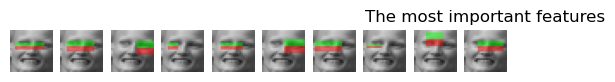

In [11]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, ax = plt.subplots(1, 10)

for idx in range(10):
    image = positive_patches[0,:,:]
    image = draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[idx_sorted[idx]]])
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.title('The most important features')
plt.show()

In [12]:
# In this example, the mask is manually initialized. In the practice, the
# feature selector computes this mask
mask = np.full(feature_coord.shape, False) 
mask[np.random.randint(0, feature_coord.shape[0], 5)] = True
print(f"Selected features from the first sample: {features[0,mask]}")

# feature_coord and feature_type stores the coordinates and types of all the features
# that can be computed in an input patch. They were computed using the function
# haar_like_feature_coord
print(f"Number of possible features: {feature_coord.shape[0]}")

# Compute only the selected features from the first positive image
sample_features = extract_feature_image(positive_patches[0,:,:], feature_type[mask], feature_coord[mask])
print(f"Features computed using the mask: {sample_features}")

Selected features from the first sample: [ 0.18458062 -0.08097649 -2.50399271 -0.18637806  4.15579385]
Number of possible features: 101400
Features computed using the mask: [ 0.18458062 -0.08097649 -2.50399271 -0.18637806  4.15579385]


### SelectKBest selector

We will start using the SelectKBest selector technique in order to keep the most useful features from all the ones that we extracted before. This method allows us to choose the top k highest-scoring features for each image. The k parameter represents the number of features to retain.

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif

# Write your code here
labels = np.zeros((features.shape[0]))
labels[:positive_patches.shape[0]] = 1 

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=320, stratify=labels, random_state=0)

clf_fs1 = RandomForestClassifier()

#define the selector that we are going to use, to start we chose to use the selectkbest selector
selector = SelectKBest(score_func=f_classif, k=2000)

#here we apply the feature selector to our dataset
X_train_selected = selector.fit_transform(X_train, y_train)

#here we can get the positions of the selected mask where true represent an important feature and false represent a non important feature
selected_mask1 = selector.get_support()

# here we apply feature selection to the test set, we have the selected_mask is an array containing true and false, so it will take only the elements of X_test 
#with the same positions as the positions of TRUE: Select only the columns/features corresponding to True values in the mask
X_test_selected = X_test[:, selected_mask1]

t_start = time()
# Train a classifier on the selected features
clf_fs1.fit(X_train_selected, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")


# Make predictions on the test set using the trained classifier
y_pred = clf_fs1.predict(X_test_selected)

# Calculate accuracy of the classifier
print(f"Test success: {np.sum(y_pred == y_test)/len(y_test)}")

Training finished in 0.5551803112030029 s
Test success: 0.9878260869565217


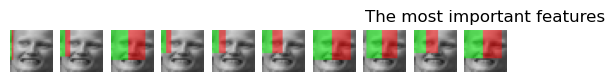

In [41]:
idx_sorted = np.argsort(clf_fs1.feature_importances_)[::-1]

fig, ax = plt.subplots(1, 10)

for idx in range(10):
    image = positive_patches[0,:,:]
    image = draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[idx_sorted[idx]]])
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.title('The most important features')
plt.show()

### VarianceThreshold

Next we applied the VarianceThreshold technique which is a simple baseline approach to feature selection. It eliminates features with low variance, considering them less informative for the objective of classification.

In [77]:
from sklearn.feature_selection import VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=320, stratify=labels, random_state=0)

clf_fs2 = RandomForestClassifier()
# for the second approach we are going to use the variance theshhold where it removes all features whose variance doesn’t meet some threshold
#define the selector that we are going to use
threshold = 0.5
selector = VarianceThreshold(threshold)

#we apply the feature selector to our dataset
X_train_selected = selector.fit_transform(X_train, y_train)

#here we can get the positions of the selected mask where true represent an important feature and false represent a non important feature
selected_mask2 = selector.get_support()

# here we apply feature selection to the test set, we have the selected_mask is an array containing true and false, so it will take only the elements of X_test 
#with the same positions as the positions of TRUE: Select only the columns/features corresponding to True values in the mask
X_test_selected = X_test[:, selected_mask2]

t_start = time()
# Train a classifier on the selected features
clf_fs2.fit(X_train_selected, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")

# Make predictions on the test set using the trained classifier
y_pred = clf_fs2.predict(X_test_selected)

# Calculate accuracy of the classifier
print(f"Test success: {np.sum(y_pred == y_test)/len(y_test)}")

Training finished in 2.69197416305542 s
Test success: 0.9843478260869565


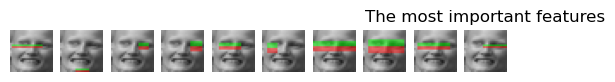

In [43]:
idx_sorted = np.argsort(clf_fs2.feature_importances_)[::-1]

fig, ax = plt.subplots(1, 10)

for idx in range(10):
    image = positive_patches[0,:,:]
    image = draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[idx_sorted[idx]]])
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.title('The most important features')
plt.show()

Tree classifier and model

In [44]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=320, stratify=labels, random_state=0)

clf_fs3 = RandomForestClassifier()

#define the decision tree classifier
tree_clf = ExtraTreesClassifier(n_estimators=100)
#fit it to our dataset
tree_clf = tree_clf.fit(X_train, y_train)

#define the selector which will take the most important features after with the help of the decision tree classifier
selector = SelectFromModel(tree_clf, prefit=True)
#apply the selector to our train data
X_train_selected = selector.transform(X_train)
selected_mask3= selector.get_support()

# here we apply feature selection to the test set, we have the selected_mask is an array containing true and false, so it will take only the elements of X_test 
#with the same positions as the positions of TRUE: Select only the columns/features corresponding to True values in the mask
X_test_selected = X_test[:, selected_mask3]

t_start = time()
# Train a classifier on the selected features
clf_fs3.fit(X_train_selected, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")

# Make predictions on the test set using the trained classifier
y_pred = clf_fs3.predict(X_test_selected)

# Calculate accuracy of the classifier
print(f"Test success: {np.sum(y_pred == y_test)/len(y_test)}")

[0. 0. 0. ... 0. 0. 0.]
Training finished in 0.44316577911376953 s
Test success: 0.9843478260869565


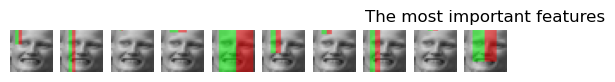

In [45]:
idx_sorted = np.argsort(clf_fs3.feature_importances_)[::-1]

fig, ax = plt.subplots(1, 10)

for idx in range(10):
    image = positive_patches[0,:,:]
    image = draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[idx_sorted[idx]]])
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.title('The most important features')
plt.show()

Using a sliding window approach

[]

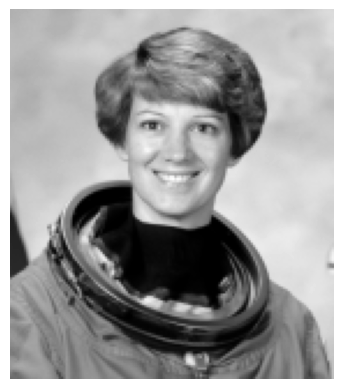

In [74]:
# Test image
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.plot()

In [37]:
def detect_faces(image, clf,threshold, mask=None, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES):
    # Write your code here
    window_shape= orig_size
    stride = (10, 10)
    #get the dimension of the image
    image_height, image_width = image.shape[:2]
    #get the dimension of the window
    window_height, window_width = window_shape
    stride_y, stride_x = stride
    #create an empty list to store the corrdinates of the windows where we detected faces
    coords=[]
    for y in range(0, image_height - window_height + 1, stride_y):
        for x in range(0, image_width - window_width + 1, stride_x):
            #getting the window
            window = image[y:y+window_height, x:x+window_width]
            #rescale the window to the shape of (25,25)
            face_rescaled = resize(window, patch_size)
            # extract the Haar_like features from the window
            features = np.vstack([extract_feature_image(face_rescaled, FEATURE_TYPES)])
            if mask is not None :
                features = features[:, mask]
            #predict if that window is a face or not
            face_pred = clf.predict_proba(features)
            #take the number of the position 1 which is for the class1 which is a face
            face_proba = face_pred[0][1]
            #print(face_proba)
            if face_proba > threshold:
                coords.append((y,x))
    return coords

Detect faces using all features: 17.667163610458374 s


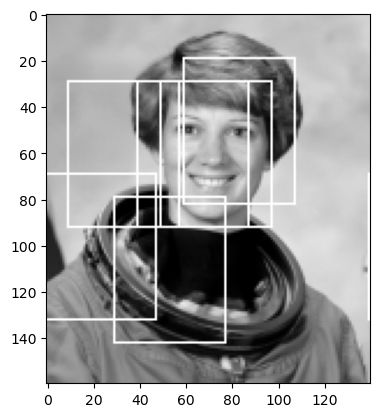

In [54]:
t_start = time()
coords = detect_faces(test_image, clf,threshold=0.5, mask=None, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using all features: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

Detect faces using all features: 17.822367668151855 s


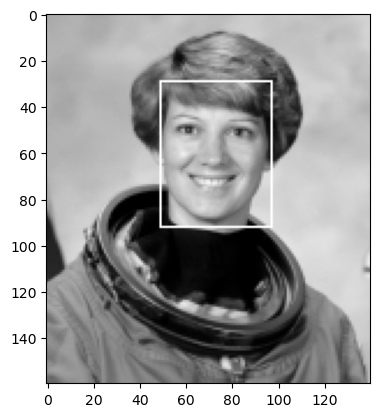

In [55]:
t_start = time()
coords = detect_faces(test_image, clf,threshold=0.6, mask=None, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using all features: {time()-t_start} s")

test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

### Test image with KBestSelector features

Detect faces using feature selection: 17.234394311904907 s


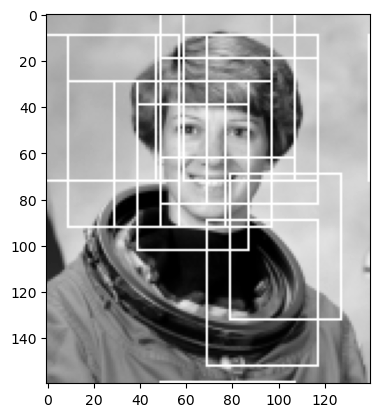

In [56]:
t_start = time()
coords = detect_faces(test_image, clf_fs1,threshold=0.5, mask=selected_mask1, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

Detect faces using feature selection: 17.072395086288452 s


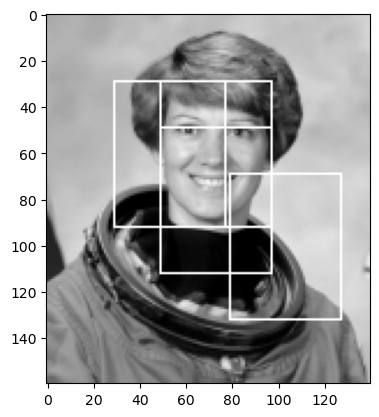

In [75]:
t_start = time()
coords = detect_faces(test_image, clf_fs1,threshold=0.6, mask=selected_mask1, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

Detect faces using feature selection: 17.216756105422974 s


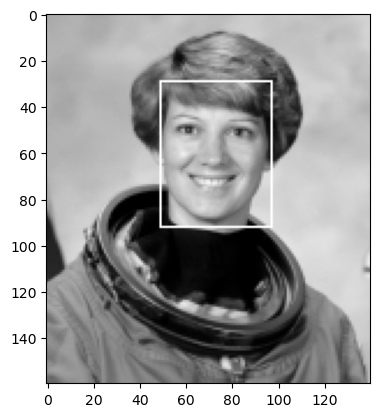

In [76]:
t_start = time()
coords = detect_faces(test_image, clf_fs1,threshold=0.7, mask=selected_mask1, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

### Test with VarianceThreshold features

Detect faces using feature selection: 16.58439612388611 s


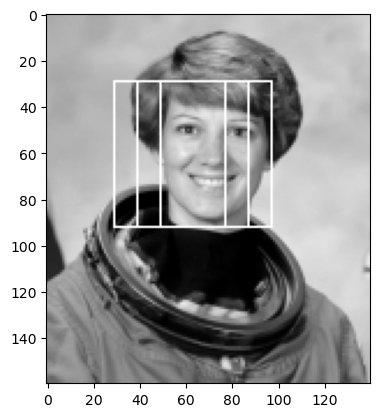

In [59]:
t_start = time()
coords = detect_faces(test_image, clf_fs2,threshold=0.5, mask=selected_mask2, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

Detect faces using feature selection: 16.598484754562378 s


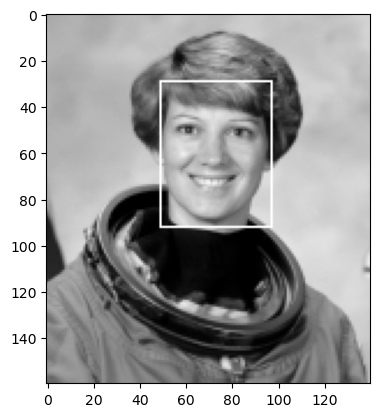

In [60]:
t_start = time()
coords = detect_faces(test_image, clf_fs2,threshold=0.6, mask=selected_mask2, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

### Test with DecisionTreeclassifier and SelectFromModel transformer

Detect faces using feature selection: 16.791343212127686 s


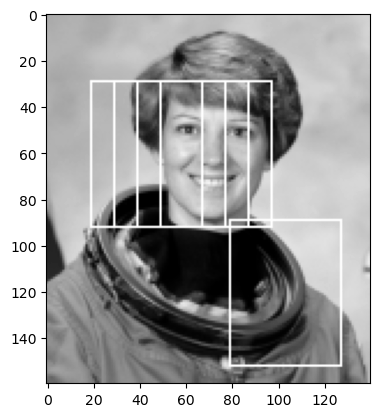

In [61]:
t_start = time()
coords = detect_faces(test_image, clf_fs3,threshold=0.5, mask=selected_mask3, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()

Detect faces using feature selection: 16.79726219177246 s


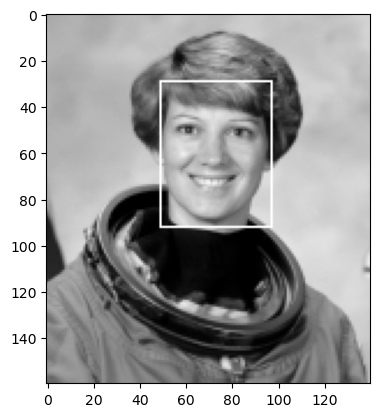

In [62]:
t_start = time()
coords = detect_faces(test_image, clf_fs3,threshold=0.6, mask=selected_mask3, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES)
print(f"Detect faces using feature selection: {time()-t_start} s")
test_image_cpy = test_image * 1
for start in coords:
    rows, cols = skimage.draw.rectangle_perimeter(start=start, extent=(62,47))
    test_image_cpy[rows, cols] = 1
plt.imshow(test_image_cpy, cmap="gray")
plt.show()